In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
import sys
from tqdm import tqdm
import os
import random
import pickle
from glob import glob
import gc
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric
from utils.feature_contena import Features
from utils.pandas_utils import reduce_mem_usage

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
config = f"""
execution:
    exp_id: exp_030
    debug: False
    submit: False
    multiprocessing: True

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    step_csv_dir: /kaggle/input/save_series_csv/csvs
    oof_exp: exp_028

feature:
    agg_freq: 24 # [step]

xgboost:    
    objective: "reg:squarederror"
    learning_rate: 0.01  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 7  # 3-8。7くらいでいい。
    colsample_bytree: 0.5  # カラムが多い時は少なめ(0.4とか)にする。
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

In [3]:
sub = pd.read_csv(f'/kaggle/output/{CFG["dataset"]["oof_exp"]}/submission.csv')
oof = pd.read_csv(f'/kaggle/output/{CFG["dataset"]["oof_exp"]}/oof.csv')
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
display(sub.head())
display(oof.head())
display(labels.head())

,series_id,raw_step,event,score,step
0,038441c925bb,10859.5,wakeup,0.618343,10847
1,038441c925bb,24011.5,wakeup,-0.086836,23999
2,038441c925bb,27467.5,wakeup,0.890253,27455
3,038441c925bb,44147.5,wakeup,0.689371,44135
4,038441c925bb,61163.5,wakeup,0.636899,61151


,target,step,series_id,fold,oof_stage1,STAGE_stage1,raw_oof,oof_stage2,STAGE_stage2,minutes,oof
0,1,11.5,038441c925bb,2,NaN,2,0.999819,NaN,NaN,NaN,NaN
1,1,35.5,038441c925bb,2,NaN,2,0.999644,NaN,NaN,NaN,NaN
2,1,59.5,038441c925bb,2,NaN,2,0.993865,NaN,NaN,NaN,NaN
3,1,83.5,038441c925bb,2,NaN,2,0.995005,NaN,NaN,NaN,NaN
4,1,107.5,038441c925bb,2,NaN,2,0.994551,NaN,NaN,NaN,NaN


,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


## 正解ラベルを作成

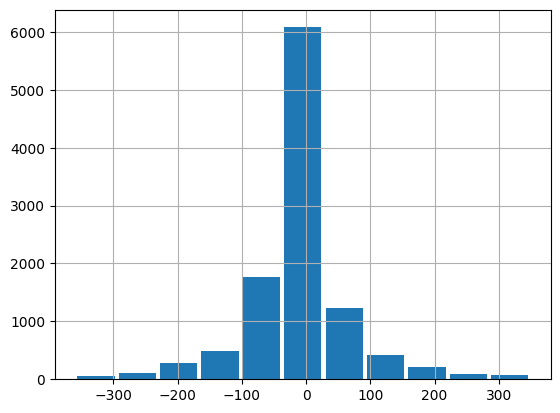

series_id    5331163
step         5331163
fold         5331163
raw_oof      5331163
minutes       692642
target         10826
sub_step       10826
raw_step       10826
event          10826
score          10826
dtype: int64

In [4]:
dfs = []
for (series_id, event), label_df in labels.groupby(["series_id", "event"]):
    sub_df = sub[(sub["series_id"] == series_id) & (sub["event"] == event)].reset_index(drop=True)
    targets = np.empty(len(sub_df))
    for i, sub_step in enumerate(sub_df["step"].values):
        best_step = np.inf
        for step in label_df["step"].values:
            if abs(step - sub_step) < abs(best_step - sub_step):
                best_step = step
        target = best_step - sub_step
        if abs(target) > 360:
            target = 0
        targets[i] = target
    sub_df["target"] = targets
    sub_df["sub_step"] = sub_df["step"].values
    dfs.append(sub_df)
sub = pd.concat(dfs).reset_index(drop=True)
plt.hist(sub["target"].values, bins=11, rwidth=0.9)
plt.grid()
plt.show()

oof = oof[["series_id", "step", "fold", "raw_oof", "minutes"]].merge(
    sub[["target", "series_id", "sub_step", "raw_step", "event", "score"]], 
    left_on=["series_id", "step"], 
    right_on=["series_id", "raw_step"], 
    how="left",
    )
(~oof.isna()).sum()

In [5]:
(oof.target ** 2).mean() ** 0.5

81.95849442732367

In [6]:
oof.head()

,series_id,step,fold,raw_oof,minutes,target,sub_step,raw_step,event,score
0,038441c925bb,11.5,2,0.999819,NaN,NaN,NaN,NaN,NaN,NaN
1,038441c925bb,35.5,2,0.999644,NaN,NaN,NaN,NaN,NaN,NaN
2,038441c925bb,59.5,2,0.993865,NaN,NaN,NaN,NaN,NaN,NaN
3,038441c925bb,83.5,2,0.995005,NaN,NaN,NaN,NaN,NaN,NaN
4,038441c925bb,107.5,2,0.994551,NaN,NaN,NaN,NaN,NaN,NaN


## 特徴生成

In [7]:
def generate_oof_features(train: pd.DataFrame):    
    features = Features()

    # gap
    train["gap"] = train["sub_step"] - train["step"]
    train["sub_minutes"] = (train["minutes"] + train["gap"] * 12) % (60 * 60)
    features.add_num_features(["gap", "sub_minutes"])

    columns = ["raw_oof"]

    # その人のその時刻での平均的な測定値
    train["total_seconds"] = train.index * 5 *  CFG["feature"]["agg_freq"] % (24 * 60 * 60)
    gb = train.groupby("total_seconds")[columns].mean()
    gb.columns = [f"{c}_mean" for c in columns]
    train["raw_oof_mean"] = train["total_seconds"].map(gb["raw_oof_mean"])
    features.add_num_features(gb.columns.tolist())

    # diff
    f_names = [f"{c}_diff_abs" for c in columns]
    train[f_names] = train[columns].diff().abs()
    features.add_num_features(f_names)

    columns += f_names
    columns += gb.columns.tolist()

    # rolling
    dts = [1, 2, 3, 5, 10, 50]
    shift_features_dic = {}
    for dt in dts:       
        shift_features = []

        f_names = [f"{c}_rolling_mean_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).mean()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_std_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).std()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_max_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).max()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_min_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).min()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_median_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).median()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_square_mean_{dt}" for c in columns]
        train[f_names] = ((train[columns] ** 2).rolling(dt, center=True).mean())
        features.add_num_features(f_names)
        shift_features += f_names

        shift_features_dic[dt] = shift_features

    # shift
    for dt, shift_features in shift_features_dic.items():
        for c in [0.5, 1, 2]:
            _dt = int(dt * c)
            if _dt == 0:
                continue
            f_names_plus = [f"{c}_shift_{_dt}" for c in shift_features]
            train[f_names_plus] = train[shift_features].shift(_dt)
            features.add_num_features(f_names_plus)

            f_names_minus = [f"{c}_shift_{-_dt}" for c in shift_features]
            train[f_names_minus] = train[shift_features].shift(-_dt)
            features.add_num_features(f_names_minus)

            f_names_diff = [f"{c}_shift_{_dt}_diff" for c in shift_features]
            train[f_names_diff] = train[f_names_plus].values - train[f_names_minus].values
            features.add_num_features(f_names_diff)

    train = train.dropna(subset=["target"]).reset_index(drop=True)
    train = reduce_mem_usage(train)
    gc.collect()
    return train, features

In [11]:
def generate_sensor_features(train: pd.DataFrame):
    features = Features()

    # 時刻
    timestamp = pd.to_datetime(train["timestamp"].values[0])
    total_seconds = (timestamp - timestamp.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    train["s_total_seconds"] = (total_seconds + train.index * 5) % (24 * 60 * 60) # [sec]
    train["s_minutes"] = train["s_total_seconds"] % (60 * 60)
    features.add_num_features(["s_total_seconds", "s_minutes"])    

    columns = ["anglez", "enmo"]

    # その人のその時刻での平均的な測定値
    gb = train.groupby("s_total_seconds")[columns].mean()
    gb.columns = [f"{c}_mean" for c in columns]
    train["anglez_mean"] = train["s_total_seconds"].map(gb["anglez_mean"])
    train["enmo_mean"] = train["s_total_seconds"].map(gb["enmo_mean"])
    features.add_num_features(gb.columns.tolist())

    # diff
    f_names = [f"{c}_diff_abs" for c in columns]
    train[f_names] = train[columns].diff().abs()
    features.add_num_features(f_names)

    columns += f_names
    columns += gb.columns.tolist()

    # rolling
    dts = [10, 50, 100, 1000]
    shift_features_dic = {}
    for dt in dts:       
        shift_features = []

        f_names = [f"{c}_rolling_mean_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).mean()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_std_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).std()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_max_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).max()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_min_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).min()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_median_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).median()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_square_mean_{dt}" for c in columns]
        train[f_names] = ((train[columns] ** 2).rolling(dt, center=True).mean())
        features.add_num_features(f_names)
        shift_features += f_names

        shift_features_dic[dt] = shift_features

    # 一定stepで集約
    series_id = train["series_id"].values[0]
    agg_freq = CFG["feature"]["agg_freq"]
    columns = features.all_features() + ["target", "step"]
    train = train[columns].groupby(train["step"].values // agg_freq).mean()
    train["series_id"] = series_id
    train["target"] = train["target"].round().astype(int)

    # shift
    for dt, shift_features in shift_features_dic.items():
        for c in [-1, -0.5, 0.5, 1]:
            c /= CFG["feature"]["agg_freq"]
            _dt = int(dt * c)
            if _dt == 0:
                continue
            f_names = [f"{c}_shift_{_dt}" for c in shift_features]
            train[f_names] = train[shift_features].shift(_dt)
            features.add_num_features(f_names)

    train = reduce_mem_usage(train)
    gc.collect()
    return train, features

In [12]:
def generate_features(train: pd.DataFrame):
    oof_train, oof_features = generate_oof_features(train)
    oof_train = oof_train.sort_values("step").reset_index(drop=True)

    series_id = train["series_id"].values[0]
    df = pd.read_csv(f"{CFG['dataset']['step_csv_dir']}/{series_id}.csv")
    sensor_train, sensor_features = generate_sensor_features(df)

    # merge
    sensor_train = sensor_train[sensor_train["step"].isin(oof_train["step"].values)].sort_values("step").reset_index(drop=True)
    oof_train = pd.concat([oof_train, sensor_train[sensor_features.all_features()]], axis=1)

    features = Features()
    features.add_num_features(oof_features.num_features())
    features.add_cat_features(oof_features.cat_features())
    features.add_num_features(sensor_features.num_features())
    features.add_cat_features(sensor_features.cat_features())

    del sensor_train, sensor_features
    gc.collect()

    return oof_train, features    

def generate_features_for_group(group):
    _, df = group
    df, features = generate_features(df)
    return df, features

In [13]:
groups = list(oof.groupby("series_id"))

with Pool(30) as pool:
    results = list(tqdm(pool.imap(generate_features_for_group, groups), total=len(groups)))

dfs, features_list = zip(*results)
features = features_list[0]

train = pd.concat(dfs).reset_index(drop=True)
display(train.head())
print(train.shape)

del dfs, results
gc.collect()

100%|██████████| 277/277 [07:46<00:00,  1.68s/it]


,series_id,step,fold,raw_oof,minutes,target,sub_step,raw_step,event,score,...,enmo_rolling_std_100_shift_-4,enmo_rolling_std_100_shift_2,enmo_rolling_std_100_shift_4,enmo_rolling_std_50,enmo_rolling_std_50_shift_-1,enmo_rolling_std_50_shift_-2,enmo_rolling_std_50_shift_1,enmo_rolling_std_50_shift_2,s_minutes,s_total_seconds
0,038441c925bb,5027.5,2,0.072061,1737.5,-23.0,5015.0,5027.5,onset,0.884315,...,0.000371,0.010041,0.043482,0.003357,0.000758,0.000471,0.007665,0.013029,1737.5,80937.5
1,038441c925bb,10859.5,2,0.301884,2097.5,85.0,10847.0,10859.5,wakeup,0.618343,...,0.026251,0.001265,0.000960,0.000367,0.000674,0.001903,0.000508,0.001414,2097.5,23697.5
2,038441c925bb,20435.5,2,0.220708,3177.5,-179.0,20423.0,20435.5,onset,0.569494,...,0.004345,0.001018,0.001575,0.000398,0.000335,0.000337,0.000568,0.000805,3177.5,71577.5
3,038441c925bb,24011.5,2,0.560241,3057.5,0.0,23999.0,24011.5,wakeup,-0.086836,...,0.014204,0.010184,0.014834,0.003614,0.009645,0.010885,0.002950,0.012948,3057.5,3057.5
4,038441c925bb,24083.5,2,0.426754,3417.5,0.0,24071.0,24083.5,onset,0.118984,...,0.014424,0.008543,0.010066,0.005806,0.008824,0.019108,0.010885,0.009645,3417.5,3417.5


(10826, 1623)


0

In [14]:
train["bin_event"] = train["event"].map({"onset": 0.0, "wakeup": 1.0})
features.add_num_feature("bin_event")

## 学習

In [15]:
# 学習
trn_oof, models = fit_xgb(train[features.all_features()], train["target"], train["fold"].astype(
    int), params=CFG["xgboost"], es_rounds=100)
train["oof"] = trn_oof

# 保存
for i, model in enumerate(models):
    model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:77.13973
[50]	eval-rmse:72.75049
[100]	eval-rmse:70.61520
[150]	eval-rmse:69.74960
[200]	eval-rmse:69.36918
[250]	eval-rmse:69.18142
[300]	eval-rmse:69.02851
[350]	eval-rmse:68.94169
[400]	eval-rmse:68.91463
[450]	eval-rmse:68.90937
[500]	eval-rmse:68.95629
[521]	eval-rmse:68.95662


 20%|██        | 1/5 [00:48<03:15, 48.89s/it]

== fold 1 ==
[0]	eval-rmse:83.44845
[50]	eval-rmse:78.09890
[100]	eval-rmse:75.46756
[150]	eval-rmse:74.31494
[200]	eval-rmse:73.72581
[250]	eval-rmse:73.44208
[300]	eval-rmse:73.32612
[350]	eval-rmse:73.26132
[400]	eval-rmse:73.19905
[450]	eval-rmse:73.16027
[500]	eval-rmse:73.17582
[549]	eval-rmse:73.18160


 40%|████      | 2/5 [01:25<02:05, 41.82s/it]

== fold 2 ==
[0]	eval-rmse:87.49739
[50]	eval-rmse:83.60724
[100]	eval-rmse:82.30277
[150]	eval-rmse:81.75559
[200]	eval-rmse:81.50430
[250]	eval-rmse:81.37958
[300]	eval-rmse:81.24998
[350]	eval-rmse:81.19618
[400]	eval-rmse:81.17287
[450]	eval-rmse:81.17948
[500]	eval-rmse:81.15991
[550]	eval-rmse:81.16781
[600]	eval-rmse:81.18892
[605]	eval-rmse:81.20150


 60%|██████    | 3/5 [02:05<01:22, 41.01s/it]

== fold 3 ==
[0]	eval-rmse:79.59374
[50]	eval-rmse:75.80870
[100]	eval-rmse:74.37413
[150]	eval-rmse:73.97131
[200]	eval-rmse:73.76537
[250]	eval-rmse:73.53154
[300]	eval-rmse:73.42045
[350]	eval-rmse:73.41370
[400]	eval-rmse:73.41271
[450]	eval-rmse:73.37184
[500]	eval-rmse:73.37132
[550]	eval-rmse:73.34694
[600]	eval-rmse:73.31420
[650]	eval-rmse:73.34258
[699]	eval-rmse:73.35512


 80%|████████  | 4/5 [02:51<00:43, 43.05s/it]

== fold 4 ==
[0]	eval-rmse:81.51960
[50]	eval-rmse:76.19438
[100]	eval-rmse:73.63050
[150]	eval-rmse:72.55018
[200]	eval-rmse:71.98082
[250]	eval-rmse:71.58497
[300]	eval-rmse:71.51770
[350]	eval-rmse:71.50350
[400]	eval-rmse:71.52164
[450]	eval-rmse:71.57903
[457]	eval-rmse:71.59410


100%|██████████| 5/5 [03:23<00:00, 40.66s/it]


In [16]:
train = train[["step", "sub_step", "series_id", "score", "event", "oof", "target"]]

In [17]:
train["step"] = (train["sub_step"] + train["oof"]).astype(int)

In [18]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, train)
print(f"score: {score:.4f}")
display(ap_table)

score: 0.6605


event   tolerance
onset   12           0.106332
        36           0.422998
        60           0.571895
        90           0.680752
        120          0.734569
        150          0.766267
        180          0.783740
        240          0.807899
        300          0.823148
        360          0.832818
wakeup  12           0.108429
        36           0.423981
        60           0.577848
        90           0.682421
        120          0.741192
        150          0.776997
        180          0.803127
        240          0.835477
        300          0.858270
        360          0.871925
dtype: float64